## Drawing

This notebook is for making / demoing my drawing-based images. This currently includes:

- Chinese character based art
- Shape based art

How can I actually generate art? Steps are as follows:

- Generate PNG from code below (TODO - try SVG?)
- Visit [url](https://cam.openbuilds.com), pick the Acro A1 DrawBot with scribe extension
- Upload the PNG (drag and drop works)
- Select document (single checkbox) and select the following options:
    - "Pen Plotter: (no offset)" as type of cut
    - Endmill / Pen Diameter: 1mm (TODO - different width?)
- Click "Generate G-Code", and then you can click the eye icon to preview the G-Code (and copy it)

Still haven't figured out sizes - how can we resize without changing quality? Maybe only by making it an SVG? Or just get the GCode and scale it down via hacky regex Python?

Final update - I think I should just create GCode for this directly. How? Answer: greedily. Loop around a circle, and then without even raising the pen just move back around the circle to find the closest once that's next (greedily).

In [2]:
from IPython import get_ipython

ipython = get_ipython()
ipython.run_line_magic("load_ext", "autoreload")
ipython.run_line_magic("autoreload", "2")

import copy
import pickle
import time
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import pyperclip
from IPython.display import HTML, SVG, Image, clear_output, display
from PIL import Image as PIL_Image

import drawing

## Drawing (actual pieces)

What have I learned so far?

- Going down to min size of about 0.05 will give you closer accuracy to the exact image (cause you can draw tiny things)
    - So you want it small but not too small (e.g. 0.08)
- Increasing `n_random` does help: up to about 500 is very beneficial (I guess because of the larger parameter space)
- `1050` shapes, and size range of `(0.08, 0.5)` seemed like a good starting point (but I think doing more would be okay, it wasn't too dark anywhere) and finished in under half an hour








In [100]:
mydraw = drawing.Drawing(
    target=drawing.TargetImage(
        image_path="images/cow-1b.jpg",
        weight_image_path=None,
        palette=[(0, 0, 0)],
        x=800,
        output_x=1500,
        blur_rad=2,
    ),
    n_shapes=400,
    n_random=200,
    darkness=0.15,
    negative_penalty=0.0,
    outer_bound=1/40,
    inner_bound=1/40,
    shape=drawing.Shape(
        line_type=drawing.LineType.BEZIER,
        size_range=(0.08, 0.5),
        endpoint_angle_range=(np.pi * 0.1, np.pi * 0.8),
        bezier_end_angle_range=(-np.pi * 0.8, np.pi * 0.8),
    ),
)

all_params, canvas, image, all_coords = mydraw.create_img()

display(canvas.resize((500, 500)))

canvas.save("outputs_drawing/cow_01.png")
np.savez('outputs_drawing/cow_01.npz', **all_coords)


Drawing black:  12%|█▎        | 50/400 [00:02<00:20, 17.01it/s]


KeyboardInterrupt: 

Drawing black: 100%|██████████| 600/600 [02:20<00:00,  4.27it/s]


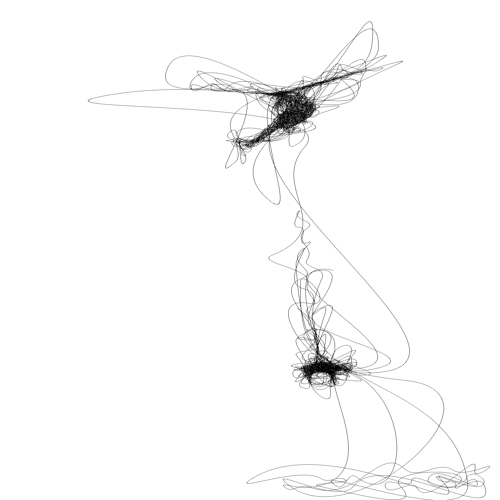

In [102]:
for i in range(1):
    mydraw = drawing.Drawing(
        target=drawing.TargetImage(
            image_path="images/cow-1e.jpg",
            weight_image_path=None,
            palette=[(0, 0, 0)],
            x=800,
            output_x=1500,
            blur_rad=2,
        ),
        n_shapes=600,
        n_random=500,
        darkness=0.12,
        negative_penalty=0.1,
        outer_bound=1/40,
        inner_bound=1/40,
        shape=drawing.Shape(
            line_type=drawing.LineType.BEZIER,
            size_range=(0.04, 0.8),
            endpoint_angle_range=(np.pi * 0.1, np.pi * 0.8),
            bezier_end_angle_range=(-np.pi * 0.8, np.pi * 0.8),
        ),
    )

    all_params, canvas, image, all_coords = mydraw.create_img(seed=3)

    display(canvas.resize((500, 500)))

    canvas.save("outputs_drawing/cow_01.png")
    np.savez('outputs_drawing/cow_01.npz', **all_coords)


In [143]:
all_coords_loaded = dict(np.load('outputs_drawing/cow_01.npz'))

center_list = [(0, 0)]
radius_list = [(80, 80)]
gcode_all = []

for center, radius in zip(center_list, radius_list):
    gcode = drawing.make_gcode(
        all_coords_loaded,
        center=center,
        radius=radius,
        speed=10_000,
        larger_dim_is_x=True,
        bound_by_largest_dim=False,
    )
    gcode_all.append(gcode)

BLACK = gcode_all[0]["black"]  # + gcode_all[1][(0, 0, 0)]
print(f"\nn_lines = {len(BLACK)}")
print(f"Total number of raise/lower commands = {len([x for x in BLACK if 'G1' not in x])}")

pyperclip.copy("\n".join(BLACK[:]))
# pyperclip.copy("\n".join(["M3S0 ; lower"] + RED[100:]))

# TODO - add estimated time (I can check how long this one took)

Bounding box:
G1 X-142.148 Y-80.000 F5000
G1 X142.148 Y-80.000 F5000
G1 X142.148 Y80.000 F5000
G1 X-142.148 Y80.000 F5000
Color black will take 6.08 minutes

n_lines = 62780
Total number of raise/lower commands = 3


Drawing black: 100%|██████████| 500/500 [00:44<00:00, 11.19it/s]


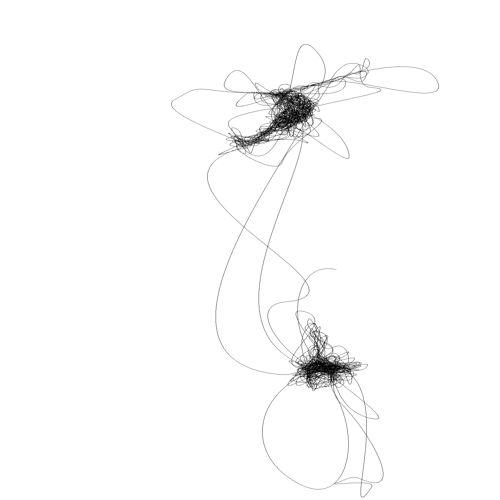

Drawing black: 100%|██████████| 500/500 [00:47<00:00, 10.62it/s]


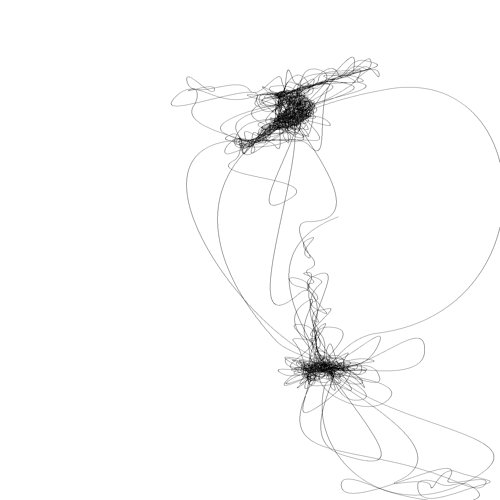

Drawing black: 100%|██████████| 500/500 [00:45<00:00, 10.92it/s]


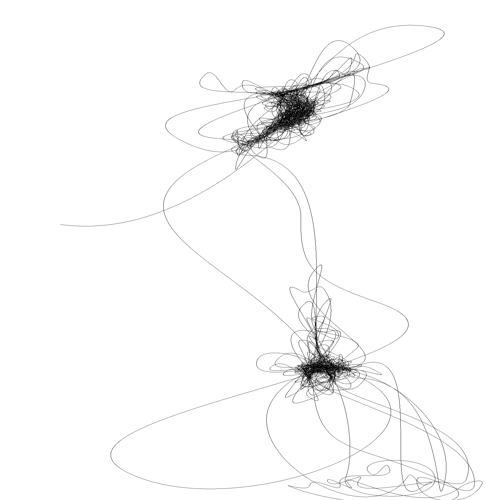

Drawing black: 100%|██████████| 500/500 [00:45<00:00, 10.90it/s]


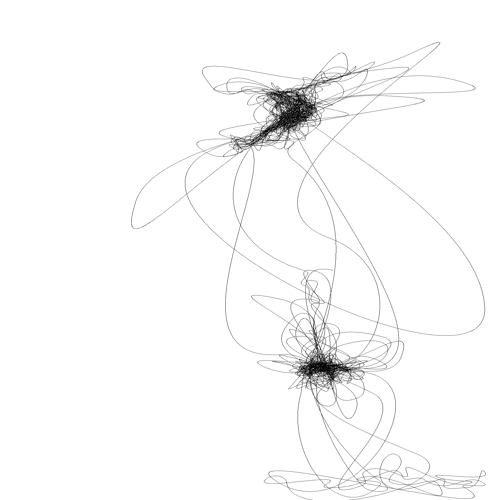

Drawing black: 100%|██████████| 500/500 [00:45<00:00, 11.04it/s]


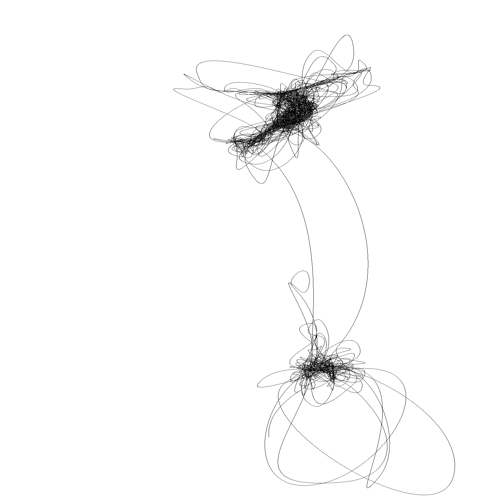

In [93]:
for i in range(5):
    mydraw = drawing.Drawing(
        target=drawing.TargetImage(
            image_path="images/cow-1e.jpg",
            weight_image_path=None,
            palette=[(0, 0, 0)],
            x=800,
            output_x=1500,
            blur_rad=2,
        ),
        n_shapes=500,
        n_random=200,
        darkness=0.12,
        negative_penalty=0.1,
        outer_bound=1/40,
        inner_bound=1/40,
        shape=drawing.Shape(
            line_type=drawing.LineType.BEZIER,
            size_range=(0.04, 0.8),
            endpoint_angle_range=(np.pi * 0.1, np.pi * 0.8),
            bezier_end_angle_range=(-np.pi * 0.8, np.pi * 0.8),
        ),
    )

    all_params, canvas, image, all_coords = mydraw.create_img(seed=i)

    display(canvas.resize((500, 500)))

    canvas.save("outputs_drawing/cow_01.png")
    np.savez('outputs_drawing/cow_01.npz', **all_coords)


FS dithering complete in 0.65s


Drawing black: 100%|██████████| 1400/1400 [01:21<00:00, 17.22it/s]


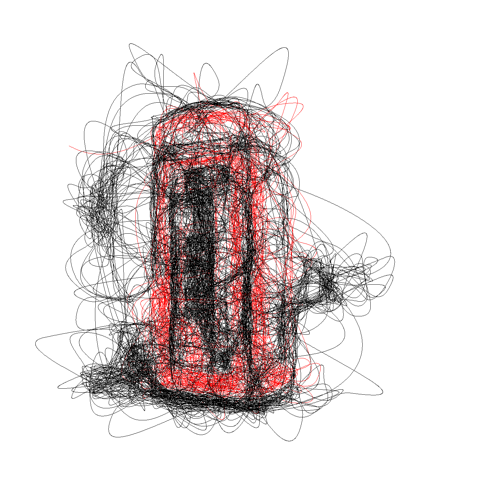

In [47]:
mydraw = drawing.Drawing(
    target=drawing.TargetImage(
        image_path="images/london_box_sketch_2b.jpg",
        weight_image_path=None,
        palette=[(255, 0, 0), (0, 0, 0)],
        x=800,
        output_x=1500,
        blur_rad=2,
    ),
    n_shapes=[450, 1400],
    n_random=200,
    darkness=[0.25, 0.16],
    negative_penalty=0.0,
    outer_bound=1/40,
    inner_bound=1/40,
    shape=drawing.Shape(
        line_type=drawing.LineType.BEZIER,
        size_range=(0.08, 0.5),
        endpoint_angle_range=(np.pi * 0.1, np.pi * 0.8),
        bezier_end_angle_range=(-np.pi * 0.8, np.pi * 0.8),
    ),
)

all_params, canvas, image, all_coords = mydraw.create_img()

display(canvas.resize((500, 500)))

canvas.save("outputs_drawing/london_box_sketch_02.png")
np.savez('outputs_drawing/london_box_sketch_02.npz', **all_coords)


FS dithering complete in 0.65s


Drawing black: 100%|██████████| 1600/1600 [02:00<00:00, 13.32it/s]


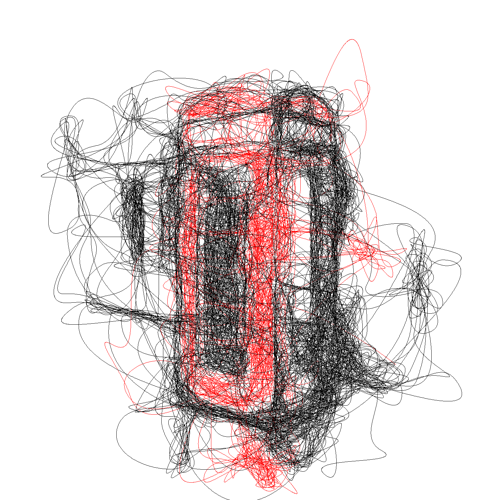

In [48]:
mydraw = drawing.Drawing(
    target=drawing.TargetImage(
        image_path="images/london_box_sketch_1b.jpg",
        weight_image_path=None,
        palette=[(255, 0, 0), (0, 0, 0)],
        x=800,
        output_x=1500,
        blur_rad=2,
    ),
    n_shapes=[550, 1600],
    n_random=250,
    darkness=[0.27, 0.18],
    negative_penalty=0.0,
    outer_bound=1/40,
    inner_bound=1/40,
    shape=drawing.Shape(
        line_type=drawing.LineType.BEZIER,
        size_range=(0.08, 0.5),
        endpoint_angle_range=(np.pi * 0.1, np.pi * 0.8),
        bezier_end_angle_range=(-np.pi * 0.8, np.pi * 0.8),
    ),
)

all_params, canvas, image, all_coords = mydraw.create_img()

display(canvas.resize((500, 500)))

canvas.save("outputs_drawing/london_box_sketch_01.png")
np.savez('outputs_drawing/london_box_sketch_01.npz', **all_coords)


FS dithering complete in 0.65s


Drawing black: 100%|██████████| 1600/1600 [06:07<00:00,  4.35it/s]


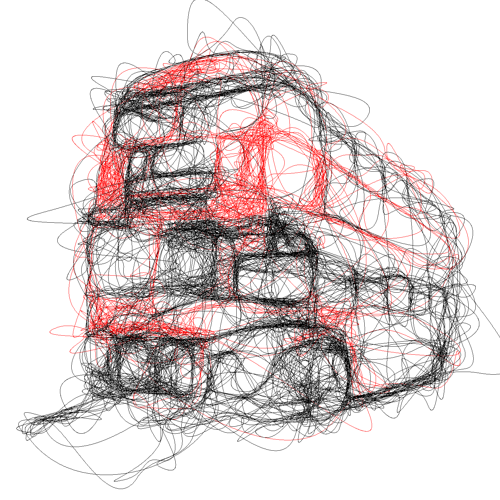

In [43]:
mydraw = drawing.Drawing(
    target=drawing.TargetImage(
        image_path="images/london_bus_sketch_2e.jpg",
        weight_image_path=None,
        palette=[(255, 0, 0), (0, 0, 0)],
        x=800,
        output_x=1500,
        blur_rad=2,
    ),
    n_shapes=[550, 1600],
    n_random=500,
    darkness=[0.27, 0.18],
    negative_penalty=0.0,
    outer_bound=1/40,
    inner_bound=1/40,
    shape=drawing.Shape(
        line_type=drawing.LineType.BEZIER,
        size_range=(0.08, 0.5),
        endpoint_angle_range=(np.pi * 0.1, np.pi * 0.8),
        bezier_end_angle_range=(-np.pi * 0.8, np.pi * 0.8),
    ),
)

all_params, canvas, image, all_coords = mydraw.create_img()

display(canvas.resize((500, 500)))

canvas.save("outputs_drawing/london_bus_sketch_01.png")
np.savez('outputs_drawing/london_bus_sketch_01.npz', **all_coords)


In [ ]:
# Save out gcode as pickle

# with open("outputs_drawing/london_bus_sketch_1.pkl", "wb") as f:
#     pickle.dump(gcode, f)

# Load gcode back in

# with open("outputs_drawing/london_bus_sketch_1.pkl", "rb") as f:
#     gcode = pickle.load(f)

# TODO - update so that the lines which hit the edge of the image are turned into raise/lower?

center_list = [(4, 186), (299, 180)]
radius_list = [(125, 125), (125, 125)]
gcode_all = []

for center, radius in zip(center_list, radius_list):
    gcode = drawing.make_gcode(
        all_coords,
        center=center,
        radius=radius,
        speed=9_000,
    )
    # for color, lines in gcode.items():
    #     print(f"rgb{color}, n_lines = {len(lines)}")

    gcode_all.append(gcode)

RED = gcode_all[0][(255, 0, 0)] + gcode_all[1][(255, 0, 0)]
BLACK = gcode_all[0][(0, 0, 0)] + gcode_all[1][(0, 0, 0)]
print(f"n_lines red = {len(RED)}")
print(f"n_lines black = {len(BLACK)}")
print(f"Total number of raise/lower commands = {len([x for x in RED + BLACK if 'G1' not in x])}")

pyperclip.copy("\n".join(BLACK[-198285:]))
# pyperclip.copy("\n".join(["M3S0 ; lower"] + RED[100:]))

n_lines red = 386
n_lines black = 515386
Total number of raise/lower commands = 12


Drawing black: 100%|██████████| 1050/1050 [03:02<00:00,  5.76it/s]


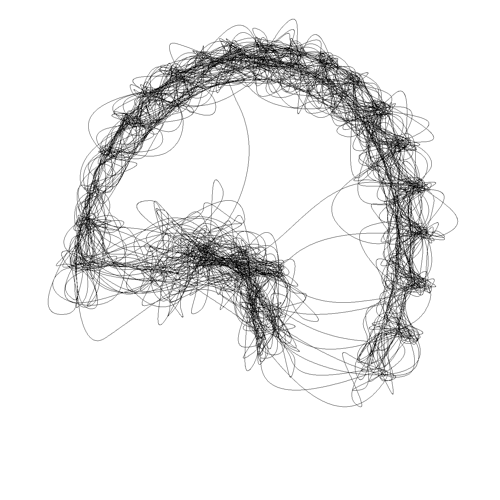

In [44]:
mydraw = drawing.Drawing(
    target=drawing.TargetImage(
        image_path="images/london_eye_3a1.jpg",
        weight_image_path=None,
        palette=[(0,0,0)],
        x=800,
        output_x=1500,
        blur_rad=2,
    ),
    n_shapes=1100,
    n_random=500,
    darkness=0.22,
    negative_penalty=0.0,
    outer_bound=1/40,
    inner_bound=1/40,
    shape=drawing.Shape(
        line_type=drawing.LineType.BEZIER,
        size_range=(0.08, 0.5),
        endpoint_angle_range=(np.pi * 0.1, np.pi * 0.8),
        bezier_end_angle_range=(-np.pi * 0.8, np.pi * 0.8),
    ),
)

params_list, canvas, image, all_coords = mydraw.create_img()

display(canvas.resize((500, 500)))

canvas.save("outputs_drawing/london_eye_01.png")
np.savez('outputs_drawing/london_eye_01.npz', **all_coords)


In [62]:
all_coords_loaded = dict(np.load('outputs_drawing/london_eye_01.npz'))

center_list = [(0, 0)]
radius_list = [(125, 125)]
gcode_all = []

for center, radius in zip(center_list, radius_list):
    gcode = drawing.make_gcode(
        all_coords_loaded,
        center=center,
        radius=radius,
        speed=10_000,
        larger_dim_is_x=True,
        bound_by_largest_dim=False,
    )
    gcode_all.append(gcode)

BLACK = gcode_all[0]["black"]  # + gcode_all[1][(0, 0, 0)]
print(f"\nn_lines = {len(BLACK)}")
print(f"Total number of raise/lower commands = {len([x for x in BLACK if 'G1' not in x])}")

pyperclip.copy("\n".join(BLACK[:]))
# pyperclip.copy("\n".join(["M3S0 ; lower"] + RED[100:]))

# TODO - add estimated time (I can check how long this one took)

Bounding box: X[-132.027, 132.027], Y[-125.000, 125.000]
Color black will take 25.79 minutes

n_lines = 163311
Total number of raise/lower commands = 3


Drawing black: 100%|██████████| 1800/1800 [08:52<00:00,  3.38it/s]


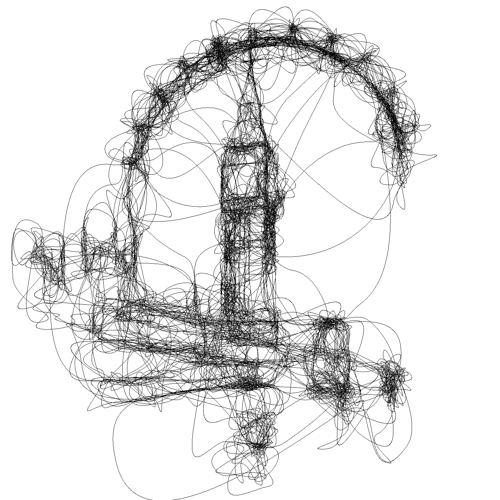

In [64]:
mydraw = drawing.Drawing(
    target=drawing.TargetImage(
        image_path="images/london-landmarks-1e.jpg",
        weight_image_path=None,
        palette=[(0, 0, 0)],
        x=1024,
        output_x=1500,
        blur_rad=2,
    ),
    n_shapes=1800,
    n_random=500,
    darkness=0.24,
    negative_penalty=0.0,
    outer_bound=1/40,
    inner_bound=1/40,
    shape=drawing.Shape(
        line_type=drawing.LineType.BEZIER,
        size_range=(0.05, 0.5),
        endpoint_angle_range=(np.pi * 0.1, np.pi * 0.8),
        bezier_end_angle_range=(-np.pi * 0.8, np.pi * 0.8),
    ),
)

all_params, canvas, image, all_coords = mydraw.create_img()

display(canvas.resize((500, 500)))
canvas.save("outputs_drawing/london_landmarks_01.png")

np.savez('outputs_drawing/london_landmarks_01.npz', **all_coords)

In [67]:
all_coords_loaded = dict(np.load('outputs_drawing/london_landmarks_01.npz'))

center_list = [(0, 0)]
radius_list = [(120, 120)]
gcode_all = []

for center, radius in zip(center_list, radius_list):
    gcode = drawing.make_gcode(
        all_coords_loaded,
        center=center,
        radius=radius,
        speed=10_000,
        larger_dim_is_x=True,
        bound_by_largest_dim=False,
    )
    gcode_all.append(gcode)

BLACK = gcode_all[0]["black"]  # + gcode_all[1][(0, 0, 0)]
print(f"\nn_lines = {len(BLACK)}")
print(f"Total number of raise/lower commands = {len([x for x in BLACK if 'G1' not in x])}")

pyperclip.copy("\n".join(BLACK[:]))
# pyperclip.copy("\n".join(["M3S0 ; lower"] + RED[100:]))

# TODO - add estimated time (I can check how long this one took)

Bounding box:
G1 X-139.330 Y-120.000 F5000
G1 X139.330 Y-120.000 F5000
G1 X139.330 Y120.000 F5000
G1 X-139.330 Y120.000 F5000
Color black will take 29.87 minutes

n_lines = 272452
Total number of raise/lower commands = 3


Drawing black: 100%|██████████| 1600/1600 [04:09<00:00,  6.42it/s]


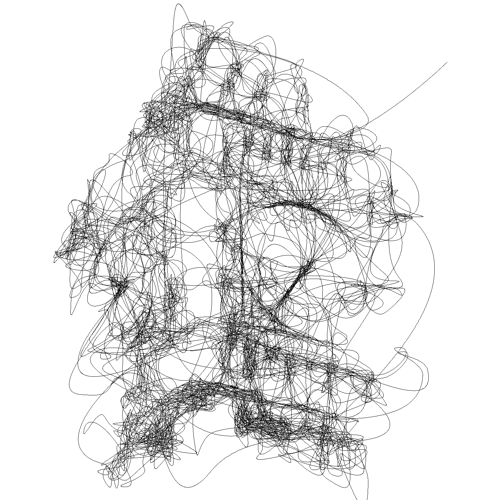

In [34]:
mydraw = drawing.Drawing(
    target=drawing.TargetImage(
        image_path="images/big-ben-2d.jpg",
        weight_image_path=None,
        palette=[(0,0,0)],
        x=800,
        output_x=1500,
        blur_rad=2,
    ),
    n_shapes=1600,
    n_random=500,
    darkness=0.25,
    negative_penalty=0.0,
    outer_bound=1/40,
    inner_bound=1/40,
    shape=drawing.Shape(
        line_type=drawing.LineType.BEZIER,
        size_range=(0.05, 0.5),
        endpoint_angle_range=(np.pi * 0.1, np.pi * 0.8),
        bezier_end_angle_range=(-np.pi * 0.8, np.pi * 0.8),
    ),
)

params_list, canvas, image, all_coords = mydraw.create_img()

display(canvas.resize((500, 500)))

canvas.save("outputs_drawing/london_big_ben_01.png")
np.savez('outputs_drawing/london_big_ben_01.npz', **all_coords)

In [58]:
all_coords_loaded = dict(np.load('outputs_drawing/london_big_ben_01.npz'))

center_list = [(0, 0)]
radius_list = [(110, 110)]
gcode_all = []

for center, radius in zip(center_list, radius_list):
    gcode = drawing.make_gcode(
        all_coords_loaded,
        center=center,
        radius=radius,
        speed=10_000,
        larger_dim_is_x=True,
        bound_by_largest_dim=False,
    )
    gcode_all.append(gcode)

BLACK = gcode_all[0]["black"]  # + gcode_all[1][(0, 0, 0)]
print(f"\nn_lines = {len(BLACK)}")
print(f"Total number of raise/lower commands = {len([x for x in BLACK if 'G1' not in x])}")

pyperclip.copy("\n".join(BLACK[:]))
# pyperclip.copy("\n".join(["M3S0 ; lower"] + RED[100:]))

# TODO - add estimated time (I can check how long this one took)

Bounding box: X[-140.836, 140.836], Y[-110.000, 110.000]
Color black will take 26.99 minutes

n_lines = 193678
Total number of raise/lower commands = 3


### Debugging / testing

(2, 25) (2, 23)
-0.030735696693893626
(2, 17) (2, 3)
(2, 30) (2, 28)


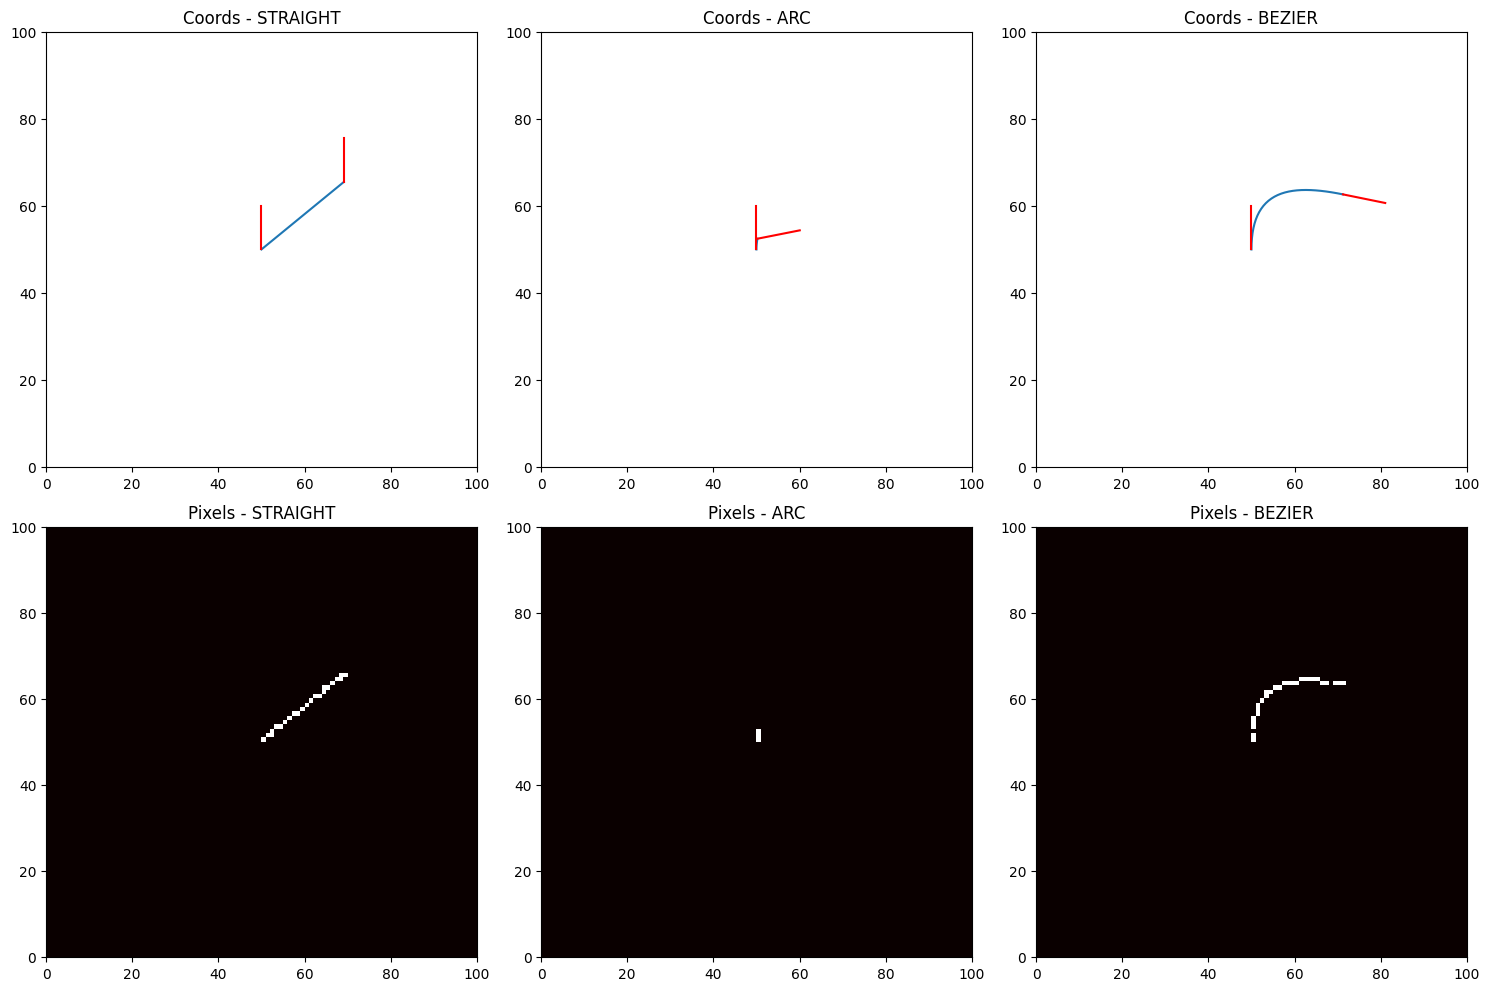

In [ ]:
SHOW_TANGENTS = True
TWO_LINES = False

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
canvas_length = 100.0
tangent_length = 0.1 * canvas_length

for i, line_type in enumerate(list(drawing.LineType)):
    # Create shape
    shape = drawing.Shape(
        line_type=line_type,
        size_range=(0.245, 0.255),
        endpoint_angle_range=(np.pi * 0.2, np.pi * 0.6),
        bezier_control_factor_range=(0.4, 0.6),
        bezier_end_angle_range=(-np.pi * 0.6, np.pi * 0.6),
    )

    # Get random parameters for shape & use them to get curve coordinates
    start_dir = np.array([1.0, 0.0])
    start_coords = np.array([50.0, 50.0])
    params = shape.get_random_params(start_coords, start_dir, canvas_length)
    coords1, pixels1, end_dir1 = shape.draw_curve(start_coords, start_dir, **params)
    end_coords1 = coords1[:, -1]

    if TWO_LINES:
        # Do this a second time, from the new position & angle
        params = shape.get_random_params(end_coords1, end_dir1, canvas_length)
        coords2, pixels2, end_dir2 = shape.draw_curve(end_coords1, end_dir1, **params)
        end_coords2 = coords2[:, -1]
        coords = np.concatenate([coords1, coords2], axis=1)
        pixels = np.concatenate([pixels1, pixels2], axis=1)
        all_dirs = [start_dir, end_dir1, end_dir2]
        all_coords = [start_coords, end_coords1, end_coords2]
    else:
        coords = coords1
        pixels = pixels1
        all_dirs = [start_dir, end_dir1]
        all_coords = [start_coords, end_coords1]

    # Plot coords
    ax_top = axes[0, i]
    ax_top.plot(coords[1], coords[0])
    if SHOW_TANGENTS:
        for dir, coords in zip(all_dirs, all_coords):
            start_end = coords + tangent_length * dir
            ax_top.plot([coords[1], start_end[1]], [coords[0], start_end[0]], "r-")
    ax_top.set_xlim(0, canvas_length)
    ax_top.set_ylim(0, canvas_length)
    ax_top.set_title(f"Coords - {line_type.name}")

    # Plot pixels
    ax_bottom = axes[1, i]
    grid = np.zeros((int(canvas_length), int(canvas_length)))
    for j in range(pixels.shape[1]):
        y, x = pixels[:, j]
        if 0 <= y < canvas_length and 0 <= x < canvas_length:
            grid[int(y), int(x)] = 1
    ax_bottom.imshow(grid, extent=[0, canvas_length, canvas_length, 0], cmap="hot")
    ax_bottom.set_xlim(0, canvas_length)
    ax_bottom.set_ylim(0, canvas_length)
    ax_bottom.set_title(f"Pixels - {line_type.name}")

plt.tight_layout()
plt.show()

## Chinese characters

Drawing shapes: 100%|██████████| 2000/2000 [00:19<00:00, 100.87it/s, filled_fraction=0.354, avg_target_img_value=0.323, best_avg_pixel_value=0.475]


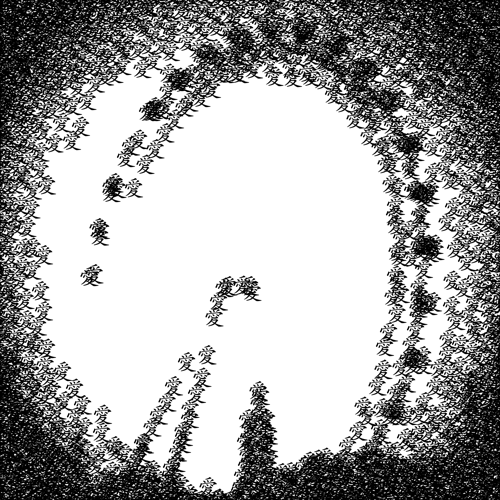

In [ ]:
params = DrawingParams(n_shapes=2000, char_size=40)

canvas = params.create_img()

# Okay finally got it looking good! Just had to keep decreasing the darkness
PIL_Image.fromarray(canvas).resize((500, 500))

Drawing shapes: 100%|██████████| 3200/3200 [00:08<00:00, 372.66it/s, filled_fraction=0.331, avg_target_img_value=0.068, best_avg_pixel_value=0.07]   


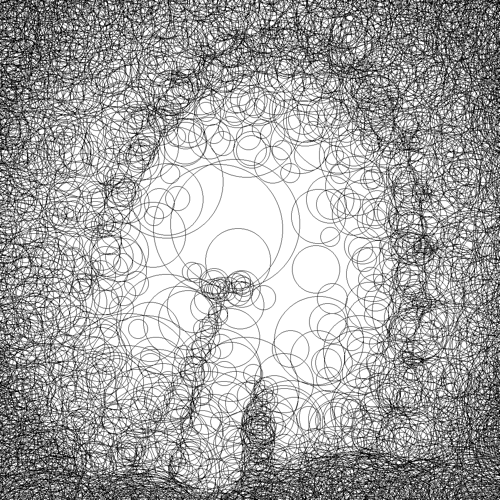

In [ ]:
params = DrawingParams(
    mode="shapes",
    n_shapes=3200,
    x=500,
    output_x=1200,
    darkness=0.45,
    shape_sizes=(10, 80),
)

canvas = params.create_img()

PIL_Image.fromarray(canvas).resize((500, 500))

Drawing shapes: 100%|██████████| 3600/3600 [00:07<00:00, 458.91it/s, filled_fraction=0.289, avg_target_img_value=0.104, best_avg_pixel_value=0.169] 


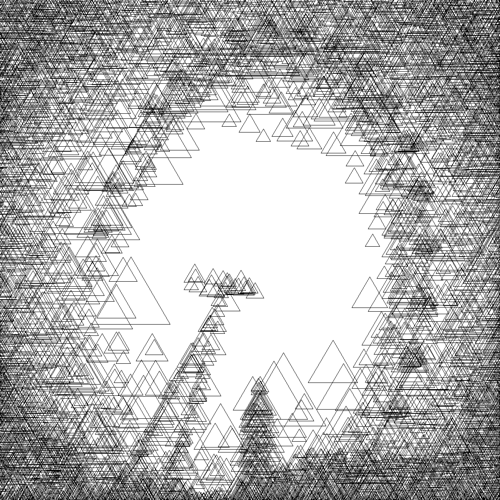

In [ ]:
params = DrawingParams(
    mode="shapes",
    shape_type="tri",
    n_shapes=3600,
    x=500,
    output_x=1200,
    darkness=0.5,
    shape_sizes=(15, 100),
)

canvas = params.create_img()

PIL_Image.fromarray(canvas).resize((500, 500))

Drawing shapes: 100%|██████████| 4000/4000 [00:08<00:00, 463.31it/s, filled_fraction=0.289, avg_target_img_value=0.167, best_avg_pixel_value=0.299] 


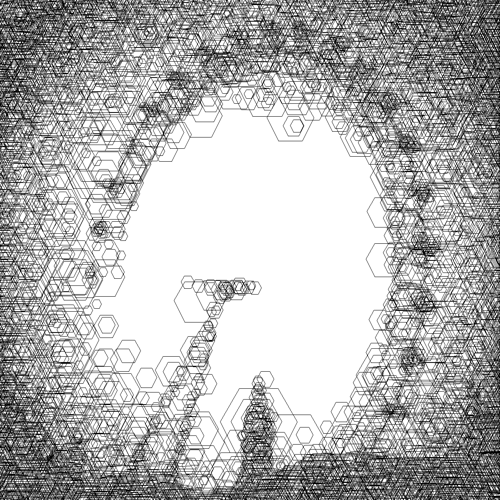

In [ ]:
params = DrawingParams(
    mode="shapes",
    shape_type="hex",
    n_shapes=4000,
    x=500,
    output_x=1200,
    darkness=0.4,
    shape_sizes=(10, 100),
)

canvas = params.create_img()

PIL_Image.fromarray(canvas).resize((500, 500))

Drawing shapes: 100%|██████████| 3000/3000 [00:07<00:00, 400.85it/s, filled_fraction=0.298, avg_target_img_value=0.194, best_avg_pixel_value=0.324]


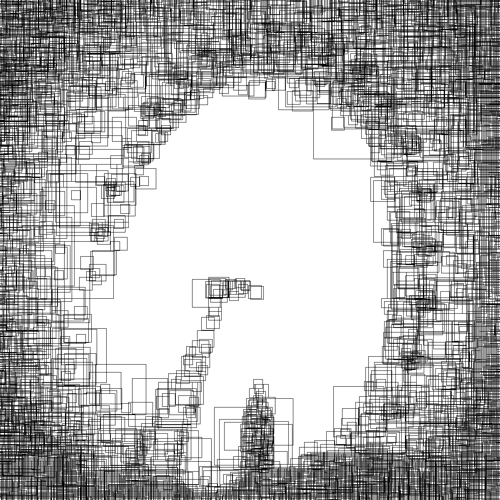

In [ ]:
params = DrawingParams(
    mode="shapes",
    shape_type="rect",
    n_shapes=3000,
    x=500,
    output_x=1200,
    darkness=0.35,
    shape_sizes=(10, 100),
)

canvas = params.create_img()

PIL_Image.fromarray(canvas).resize((500, 500))